In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [3]:
data = pd.read_csv('ab_browser_test.csv')

In [65]:
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

In [5]:
exp_clicks = np.sum(data[data.slot == 'exp']['n_clicks'])
control_clicks = np.sum(data[data.slot == 'control']['n_clicks'])

In [6]:
((exp_clicks - control_clicks) / control_clicks) * 100

1.6135689824415809

Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп.

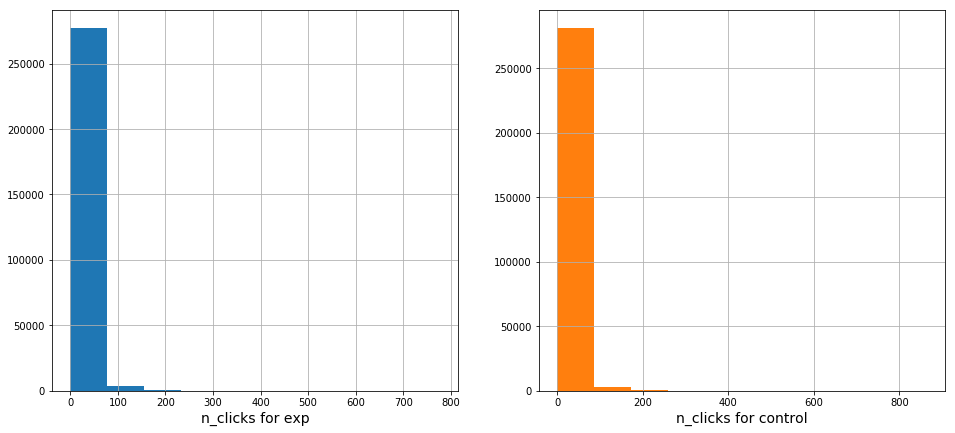

In [7]:
plt.figure(figsize=(16,7))
plt.subplot(121)
data[data.slot == 'exp']['n_clicks'].hist(color = '#1f77b4')
plt.xlabel('n_clicks for exp', fontsize=14)

plt.subplot(122)
data[data.slot == 'control']['n_clicks'].hist(color = '#ff7f0e')
plt.xlabel('n_clicks for control', fontsize=14)
plt.show()

In [5]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [6]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [7]:
exp_n_clicks = data[data.slot == 'exp'].n_clicks.values
control_n_clicks = data[data.slot == 'control'].n_clicks.values

In [12]:
%time
exp_n_clicks_mean = list(map(np.mean, get_bootstrap_samples(exp_n_clicks, 100)))
control_n_clicks_mean = list(map(np.mean, get_bootstrap_samples(control_n_clicks, 100)))

print("95% confidence interval for the default=0 LIMIT_BAL median:",  stat_intervals(exp_n_clicks_mean, 0.05))
print("95% confidence interval for the default=1 LIMIT_BAL median:",  stat_intervals(control_n_clicks_mean, 0.05))

Wall time: 0 ns
95% confidence interval for the default=0 LIMIT_BAL median: [11.52392739 11.66535274]
95% confidence interval for the default=1 LIMIT_BAL median: [11.21153964 11.34662428]


In [13]:
exp_n_clicks_median = list(map(np.median, get_bootstrap_samples(exp_n_clicks, 100)))
control_n_clicks_median = list(map(np.median, get_bootstrap_samples(control_n_clicks, 100)))

%time
print("95% confidence interval for the default=0 LIMIT_BAL median:",  stat_intervals(exp_n_clicks_median, 0.05))
print("95% confidence interval for the default=1 LIMIT_BAL median:",  stat_intervals(control_n_clicks_median, 0.05))

Wall time: 0 ns
95% confidence interval for the default=0 LIMIT_BAL median: [5. 5.]
95% confidence interval for the default=1 LIMIT_BAL median: [4. 4.]


In [15]:
delta_mean_scores = list(map(lambda x: x[1] - x[0], zip(control_n_clicks_mean, exp_n_clicks_mean)))
print( "95% confidence interval for the difference between medians",  stat_intervals(delta_mean_scores, 0.05))

95% confidence interval for the difference between medians [0.22112145 0.42219774]


1. Получите из данных n_boot_samples псевдовыборок.
2. По каждой из этих выборок посчитайте среднее и сумму квадратов отклонения от выборочного среднего (control_boot_chi_squared)
3. Для получившегося вектора средних значений из n_boot_samples постройте q-q plot с помощью scipy.stats.probplot для нормального распределения
4. Для получившегося вектора сумм квадратов отклонения от выборочного среднего постройте qq-plot

In [8]:
from scipy import stats

In [9]:
np.random.seed(0)
n_boot_samples = 500
samples = get_bootstrap_samples(control_n_clicks, n_boot_samples)

In [11]:
means = samples.mean(axis=1)

In [12]:
control_boot_chi_squared = np.sum((samples - means[:, np.newaxis])**2, axis=1)

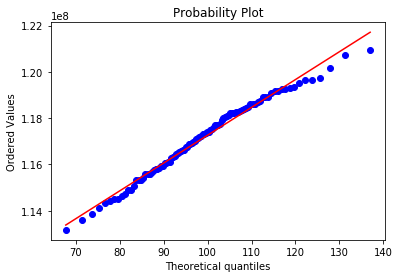

In [21]:
osm, osr = stats.probplot(control_boot_chi_squared, dist='chi2', sparams=(n_boot_samples - 1), plot=plt)

In [24]:
osr[2]

0.9929013674802593

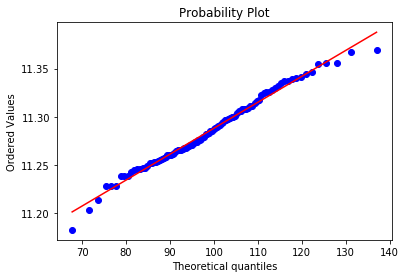

In [25]:
osm, osr = stats.probplot(means, dist='chi2', sparams=(n_boot_samples - 1), plot=plt)

In [26]:
osr[2]

0.9943275108858584

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости?

In [60]:
exp_data = data[data.slot == 'exp']
control_data = data[data.slot == 'control']

In [61]:
exp_data.drop(['slot'], axis=1, inplace=True)
control_data.drop(['slot'], axis=1, inplace=True)

C:\Users\d.v.kulemin.UTMN\AppData\Local\Programs\Python\Python37-32\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [62]:
aggregation_functions = {'browser': 'first', 
                         'n_clicks': 'sum', 
                         'n_queries': 'sum', 
                         'n_nonclk_queries': 'sum'}
exp_data = exp_data.groupby(exp_data['userID']).aggregate(aggregation_functions)
control_data = control_data.groupby(control_data['userID']).aggregate(aggregation_functions)

In [67]:
stats.mannwhitneyu(exp_data.n_clicks, control_data.n_clicks)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с α=0.05

Какое заключение можно сделать исходя из полученных результатов ?

В качестве ответа введите количество незначимых изменений с точки зрения результатов, полученных после введения коррекции.

In [68]:
unique_browsers = np.unique(data.browser)

In [69]:
unique_browsers

array(['Browser #14', 'Browser #17', 'Browser #2', 'Browser #20',
       'Browser #22', 'Browser #4'], dtype=object)

In [70]:
exp_data = data[data.slot == 'exp']
control_data = data[data.slot == 'control']

In [77]:
tests = []

for brwsr in unique_browsers:
    stat, p = stats.mannwhitneyu(exp_data[exp_data.browser == brwsr]['n_clicks'], 
                                 control_data[control_data.browser == brwsr]['n_clicks'])
    tests.append([brwsr, stat, p])

In [79]:
brwsr_clicks = pd.DataFrame.from_records(tests)
brwsr_clicks.columns = ['browser', 'statistic', 'p']

In [80]:
brwsr_clicks

,browser,statistic,p
0,Browser #14,8.069847e+08,0.000000
1,Browser #17,1.313897e+08,0.037401
2,Browser #2,1.522573e+09,0.027244
3,Browser #20,1.437918e+08,0.453667
4,Browser #22,2.547598e+09,0.257406
5,Browser #4,3.072448e+09,0.407606


In [81]:
import statsmodels.stats.multitest as smm

In [83]:
reject, p_corrected, a1, a2 = smm.multipletests(brwsr_clicks.p, 
                                            alpha = 0.05, 
                                            method = 'fdr_bh')

In [84]:
brwsr_clicks['p_corrected'] = p_corrected
brwsr_clicks['reject'] = reject

In [85]:
brwsr_clicks

,browser,statistic,p,p_corrected,reject
0,Browser #14,8.069847e+08,0.000000,0.000000,True
1,Browser #17,1.313897e+08,0.037401,0.074801,False
2,Browser #2,1.522573e+09,0.027244,0.074801,False
3,Browser #20,1.437918e+08,0.453667,0.453667,False
4,Browser #22,2.547598e+09,0.257406,0.386108,False
5,Browser #4,3.072448e+09,0.407606,0.453667,False


Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать.

Сходятся ли результаты проведенного Вами анализа с показателем процента некликнутых запросов?

In [93]:
props = []

for brwsr in unique_browsers:
    exp_n_nonclk = np.sum(exp_data[exp_data.browser == brwsr]['n_nonclk_queries'])
    exp_n = np.sum(exp_data[exp_data.browser == brwsr]['n_queries'])
    control_n_nonclk = np.sum(control_data[control_data.browser == brwsr]['n_nonclk_queries'])
    control_n = np.sum(control_data[control_data.browser == brwsr]['n_queries'])
    props.append([brwsr, (exp_n_nonclk / exp_n) * 100, (control_n_nonclk / control_n) * 100])

In [94]:
nonclk_queries_props = pd.DataFrame.from_records(props)
nonclk_queries_props.columns = ['browser', 'exp', 'control']

In [95]:
nonclk_queries_props

,browser,exp,control
0,Browser #14,43.755617,57.590411
1,Browser #17,36.937413,36.299367
2,Browser #2,44.982747,45.962747
3,Browser #20,38.977376,40.540485
4,Browser #22,39.853947,40.593977
5,Browser #4,45.142942,46.970930
